In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import gzip, binascii, struct, numpy
import numpy as np

We will train the classifier to recognize both MNIST numbers and NON-MNIST letters. Our training plan is approximately as follows:
1) Load mnist data
2) Load non-mnist data
3) Merge both data sources into a single array
4) Merge their label into a single array
5) Split each training data set training and test.
5.1) Merge training data sets for both mnist and non-mnist
5.2) Merge test datasets
5.3) Add "empty" training set
5.4) Add "empty" test set
6) Build Tensorf-flow model
7) Train it.

In [2]:
directory = 'mnist'
train_data_filename = directory + '/train-images-idx3-ubyte.gz'
train_labels_filename = directory + '/train-labels-idx1-ubyte.gz'
test_data_filename = directory + '/t10k-images-idx3-ubyte.gz'
test_labels_filename = directory + '/t10k-labels-idx1-ubyte.gz'

## Load MNIST dataset
 Extract the images into a 4D tensor [image index, y, x, channels]. For greyscale MNIST, the number of channels is always 1. Values are rescaled from [0, 255] down to [-0.5, 0.5].

First, images:

In [3]:
IMAGE_SIZE = 28
PIXEL_DEPTH = 255

def extract_data(filename, num_images):
  print ('Extracting', filename)
  with gzip.open(filename) as bytestream:
    # Skip the magic number and dimensions; we know these values.
    bytestream.read(16)
    
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
    data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
    data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, 1)
    return data

train_data_mnist = extract_data(train_data_filename, 60000)
test_data_mnist = extract_data(test_data_filename, 10000)
train_data_mnist.shape
#plt.imshow(train_data[0].reshape(28, 28))

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz


(60000, 28, 28, 1)

Now, load MNIST labels

In [4]:
NUM_LABELS = 20

def extract_labels(filename, num_images):
  """Extract the labels into a 1-hot matrix [image index, label index]."""
  print ('Extracting', filename)
  with gzip.open(filename) as bytestream:
    # Skip the magic number and count; we know these values.
    bytestream.read(8)
    
    buf = bytestream.read(1 * num_images)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8)
  # Convert to dense 1-hot representation.
  return (numpy.arange(NUM_LABELS) == labels[:, None]).astype(numpy.float32)

train_labels_mnist = extract_labels(train_labels_filename, 60000)
test_labels_mnist = extract_labels(test_labels_filename, 10000)

print('Done')

Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Done


### Split the training data into 2 sets: training , validation

In [5]:
VALIDATION_SIZE = 5000

valid_data_mnist = train_data_mnist[:VALIDATION_SIZE, :, :, :]
valid_labels_mnist = train_labels_mnist[:VALIDATION_SIZE]
train_data_mnist = train_data_mnist[VALIDATION_SIZE:, :, :, :]
train_labels_mnist = train_labels_mnist[VALIDATION_SIZE:]

print('Data:', 'Train', 'Valid', 'Test', train_data_mnist.shape, valid_data_mnist.shape, test_data_mnist.shape)
print('Labels:', 'Train', 'Valid', 'Test', train_labels_mnist.shape, valid_labels_mnist.shape, test_labels_mnist.shape)

Data: Train Valid Test (55000, 28, 28, 1) (5000, 28, 28, 1) (10000, 28, 28, 1)
Labels: Train Valid Test (55000, 20) (5000, 20) (10000, 20)


## Load NON-MNIST Dataset

In [6]:
import pickle

In [7]:
pickle_file = directory + '/notMNIST.pickle'
f = open(pickle_file, 'rb')
data = pickle.load(f)
f.close()

nm_train_data = data['train_dataset']
nm_train_labels = data['train_labels']

nm_valid_data = data['valid_dataset']
nm_valid_labels = data['valid_labels']

nm_test_data = data['test_dataset']
nm_test_labels = data['test_labels']

print('Done')

Done


In [29]:
nm_test_data.shape

(12000, 28, 28, 1)

Reshape data array to match that of MNIST. Currently it's [N, h, w]. We want [N, h, w, channels], where in this case the channels == 1

In [8]:
nm_train_data = nm_train_data.reshape(-1, 28, 28, 1)
nm_valid_data = nm_valid_data.reshape(-1, 28, 28, 1)
nm_test_data = nm_test_data.reshape(-1, 28, 28, 1)

Shift labels by 10. The first 10 indexes are for MNIST numbers

In [9]:
shift_by = 10
nm_train_labels_real_adj = nm_train_labels + shift_by
nm_valid_labels_adj = nm_valid_labels + shift_by
nm_test_labels_adj = nm_test_labels + shift_by

Convert labels into one-hot encoding similar to MNIST

In [10]:
def to_one_hot(real_labels):
    return (numpy.arange(NUM_LABELS) == real_labels[:, None]).astype(np.float32)
nm_train_labels = to_one_hot(nm_train_labels_real_adj)
nm_valid_labels = to_one_hot(nm_valid_labels_adj)
nm_test_labels = to_one_hot(nm_test_labels_adj)

Merge data arrays:

In [11]:
train_data_all = np.concatenate((train_data_mnist, nm_train_data))
valid_data_all = np.concatenate((valid_data_mnist, nm_valid_data))
test_data_all = np.concatenate((test_data_mnist, nm_test_data))
print(train_data_all.shape, valid_data_all.shape, test_data_all.shape)

(255000, 28, 28, 1) (17000, 28, 28, 1) (22000, 28, 28, 1)


Merge label arrays:

In [12]:
train_labels_all = np.concatenate((train_labels_mnist, nm_train_labels))
valid_labels_all = np.concatenate((valid_labels_mnist, nm_valid_labels))
test_labels_all = np.concatenate((test_labels_mnist, nm_test_labels))
print(train_labels_all.shape, valid_labels_all.shape, test_labels_all.shape)

(255000, 20) (17000, 20) (22000, 20)


In [13]:
train_size = train_labels_all.shape[0]
train_size

255000

##  Build TensorFlow model

In [14]:
import tensorflow as tf

BATCH_SIZE = 120 #Each batch is the number of data we feed into NN each time
# We have only one channel in our grayscale images.
NUM_CHANNELS = 1
# The random seed that defines initialization.
SEED = 42

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.float32,shape=(BATCH_SIZE, NUM_LABELS))

# For the validation and test data, we'll just hold the entire dataset in one constant node.
validation_data_node = tf.constant(valid_data_all)
test_data_node = tf.constant(test_data_all)

print('Done')

Done


Initialize weights:

In [15]:
# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized.
conv1_weights = tf.Variable(tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED))

In [16]:
conv1_biases = tf.Variable(tf.zeros([32]))

In [17]:
conv2_weights = tf.Variable(tf.truncated_normal([5, 5, 32, 64],stddev=0.1,seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))

In [18]:
# fully connected, depth 512.
fc1_weights = tf.Variable(tf.truncated_normal([int(IMAGE_SIZE / 4 * IMAGE_SIZE / 4 * 64), 512],stddev=0.1,seed=SEED))

In [19]:
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(tf.truncated_normal([512, NUM_LABELS],stddev=0.1, seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))

In [20]:
def model(data, train=False):
  # 2D convolution, with 'SAME' padding (i.e. the output feature map has
  # the same size as the input). Note that {strides} is a 4D array whose
  # shape matches the data layout: [image index, y, x, depth].
  conv = tf.nn.conv2d(data,
                      conv1_weights,
                      strides=[1, 1, 1, 1],
                      padding='SAME')

  # Bias and rectified linear non-linearity.
  relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
  
  # Max pooling. The kernel size spec ksize also follows the layout of
  # the data. Here we have a pooling window of 2, and a stride of 2.
  pool = tf.nn.max_pool(relu,
                        ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1],
                        padding='SAME')
  conv = tf.nn.conv2d(pool,
                      conv2_weights,
                      strides=[1, 1, 1, 1],
                      padding='SAME')
  relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
  pool = tf.nn.max_pool(relu,
                        ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1],
                        padding='SAME')
  
  # Reshape the feature map cuboid into a 2D matrix to feed it to the
  # fully connected layers.
  pool_shape = pool.get_shape().as_list()
  reshape = tf.reshape(
      pool,
      [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
  # Fully connected layer. Note that the '+' operation automatically
  # broadcasts the biases.
  hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
  
  # Add a 50% dropout during training only. Dropout also scales
  # activations such that no rescaling is needed at evaluation time.
  if train:
    hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
  return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Done')

Done


### Training computation

In [21]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  logits, train_labels_node))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)
# We'll compute them only once in a while by calling their {eval()} method.
validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

print('Done')

Done


### Start Session

In [22]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Initialize all the variables we defined above.
tf.initialize_all_variables().run()

print('Done')

Done


In [23]:
# Grab the first BATCH_SIZE examples and labels.
batch_data = train_data_all[:BATCH_SIZE, :, :, :]
batch_labels = train_labels_all[:BATCH_SIZE]

# This dictionary maps the batch data (as a numpy array) to the
# node in the graph it should be fed to.
feed_dict = {train_data_node: batch_data,
             train_labels_node: batch_labels}

# Run the graph and fetch some of the nodes.
_, l, lr, predictions = s.run(
  [optimizer, loss, learning_rate, train_prediction],
  feed_dict=feed_dict)

print('Done')

Done


### Error rate calculation

In [24]:
def error_rate(predictions, labels):
  """Return the error rate and confusions."""
  correct = numpy.sum(numpy.argmax(predictions, 1) == numpy.argmax(labels, 1))
  total = predictions.shape[0]

  error = 100.0 - (100 * float(correct) / float(total))

  confusions = numpy.zeros([NUM_LABELS, NUM_LABELS], numpy.float32)
  bundled = zip(numpy.argmax(predictions, 1), numpy.argmax(labels, 1))
  for predicted, actual in bundled:
    confusions[predicted, actual] += 1
    
  return error, confusions

print('Done')

Done


### Train

In [25]:
train_size

255000

In [26]:
steps = int(train_size / BATCH_SIZE)
for step in range(steps):
  # Compute the offset of the current minibatch in the data.
  # Note that we could use better randomization across epochs.
  offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
  batch_data = train_data_all[offset:(offset + BATCH_SIZE), :, :, :]
  batch_labels = train_labels_all[offset:(offset + BATCH_SIZE)]
  # This dictionary maps the batch data (as a numpy array) to the
  # node in the graph it should be fed to.
  feed_dict = {train_data_node: batch_data,
               train_labels_node: batch_labels}
  # Run the graph and fetch some of the nodes.
  _, l, lr, predictions = s.run(
    [optimizer, loss, learning_rate, train_prediction],
    feed_dict=feed_dict)
  
  # Print out the loss periodically.
  if step % 100 == 0:
    error, _ = error_rate(predictions, batch_labels)
    print('Step {:d} of {:d}'.format(step, steps))
    print ('Mini-batch loss: {:.5f} Error: {:.5f} Learning rate: {:.5f}'.format(l, error, lr))
    print ('Validation error: {:.1f}'.format(error_rate(validation_prediction.eval(), valid_labels_all)[0]))

print('Done')

Step 0 of 2125
Mini-batch loss: 8.08755 Error: 90.83333 Learning rate: 0.01000
Validation error: 94.5
Step 100 of 2125
Mini-batch loss: 3.46176 Error: 9.16667 Learning rate: 0.01000
Validation error: 72.2
Step 200 of 2125
Mini-batch loss: 3.26778 Error: 7.50000 Learning rate: 0.01000
Validation error: 71.7
Step 300 of 2125
Mini-batch loss: 3.19688 Error: 4.16667 Learning rate: 0.01000
Validation error: 71.4
Step 400 of 2125
Mini-batch loss: 3.11848 Error: 4.16667 Learning rate: 0.01000
Validation error: 71.3


KeyboardInterrupt: 

6


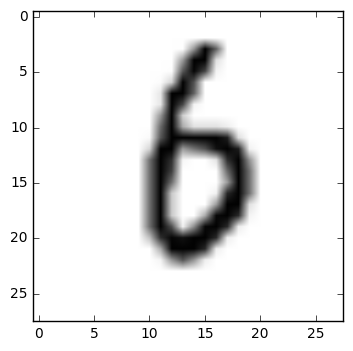

In [27]:
def draw_sample(img):
    img = img.reshape(28, 28)
    plt.imshow(img, cmap=plt.cm.Greys)

labels = '0123456789abcdefghij'
#arr = nm_valid_data
data_arr = valid_data_mnist
label_arr = valid_labels_mnist

index = 3454
draw_sample(data_arr[index])
print(labels[np.argmax(label_arr[index])])

In [28]:
train_data_all[214500]

array([[[ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5]],

       [[ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5]],

       [[ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
        [ 0.5],
    